# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs
input_file = "data/data-continental-united-states.csv"
geohash_precision = 4
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 30

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

In [3]:
from src.mermaid import build_mermaid_graph

build_mermaid_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from src.dataframes.geohash import GeohashDataFrame

geohash_dataframe = GeohashDataFrame.build(
    darwin_core_csv_lazy_frame,
    geohash_precision,
)


### Shape

In [7]:
geohash_dataframe.df.shape

(20547, 2)

### Preview

In [8]:
geohash_dataframe.df.limit(6)

geohash,neighbors
str,list[str]
"""97zz""","[""9ebn""]"
"""9ebn""","[""97zz""]"
"""9ec6""","[""9ecd"", ""9ece""]"
"""9ecd""","[""9ece"", ""9ecg"", ""9ec6""]"
"""9ece""","[""9ecg"", ""9ecu"", … ""9ec6""]"
"""9ecg""","[""9ecu"", ""9efh"", … ""9ece""]"


## `TaxonomyDataFrame`

### Build

In [9]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [10]:
taxonomy_dataframe.df.limit(3)

kingdom,phylum,class,order,family,genus,species,taxonRank,scientificName
enum,str,str,str,str,str,str,str,str
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Rosales""","""Rosaceae""","""Crataegus""","""Crataegus castlegarensis""","""SPECIES""","""Crataegus castlegarensis J.B.P…"
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Fabales""","""Fabaceae""","""Astragalus""","""Astragalus lentiginosus""","""VARIETY""","""Astragalus lentiginosus var. d…"
"""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Noctuidae""","""Sympistis""","""Sympistis aqualis""","""SPECIES""","""Sympistis aqualis Grote, 1881"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [11]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geohash_dataframe,
    geohash_precision,
)

### Shape

In [12]:
geohash_taxa_counts_dataframe.df.shape

(8123385, 5)

### Preview

In [13]:
geohash_taxa_counts_dataframe.df.limit(3)

geohash,kingdom,taxonRank,scientificName,count
str,enum,str,str,u32
"""97zz""","""Animalia""","""SPECIES""","""Eschrichtius robustus (Lilljeb…",1
"""9ebn""","""Animalia""","""SPECIES""","""Eschrichtius robustus (Lilljeb…",1
"""9ec6""","""Animalia""","""GENUS""","""Sula Brisson, 1760""",1


# `ConnectivityMatrix`

### Build

In [14]:
from src.matrices.connectivity import ConnectivityMatrix

connectivity_matrix = ConnectivityMatrix.build(geohash_dataframe)

### Preview

In [15]:
connectivity_matrix._connectivity_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], shape=(20547, 20547))

## `DistanceMatrix`

### Build

In [16]:
from src.matrices.distance import DistanceMatrix

distance_matrix = DistanceMatrix.build(
    geohash_taxa_counts_dataframe,
    geohash_dataframe,
)

### Preview

In [17]:
distance_matrix.squareform()

array([[0.        , 0.        , 0.07325887, ..., 0.05998577, 0.13867427,
        0.13370021],
       [0.        , 0.        , 0.07325887, ..., 0.05998577, 0.13867427,
        0.13370021],
       [0.07325887, 0.07325887, 0.        , ..., 0.04826531, 0.13188523,
        0.1269197 ],
       ...,
       [0.05998577, 0.05998577, 0.04826531, ..., 0.        , 0.1194596 ,
        0.11621586],
       [0.13867427, 0.13867427, 0.13188523, ..., 0.1194596 , 0.        ,
        0.16319224],
       [0.13370021, 0.13370021, 0.1269197 , ..., 0.11621586, 0.16319224,
        0.        ]], shape=(20547, 20547))

## `GeohashClusterDataFrame`

### Build

In [18]:
from src.dataframes.geohash_cluster import GeohashClusterDataFrame

geohash_cluster_dataframe = GeohashClusterDataFrame.build(
    geohash_dataframe,
    distance_matrix,
    connectivity_matrix,
    num_clusters,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 91 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


### Preview

In [19]:
geohash_cluster_dataframe.df.limit(3)

geohash,cluster
str,u32
"""97zz""",3
"""9ebn""",3
"""9ec6""",3


## `ClusterColorDataFrame`

### Build

In [20]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(geohash_cluster_dataframe)

### Preview

In [21]:
cluster_colors_dataframe.df.limit(3)

cluster,color
u32,str
0,"""#af1446"""
1,"""#c0274a"""
2,"""#d13a4e"""


## Silhouette score

In [22]:

from sklearn.metrics import silhouette_score

silhouette_score(
    X=distance_matrix.squareform(),
    labels=geohash_cluster_dataframe.df["cluster"],
    metric="precomputed",
)


np.float64(-0.10458728310306267)

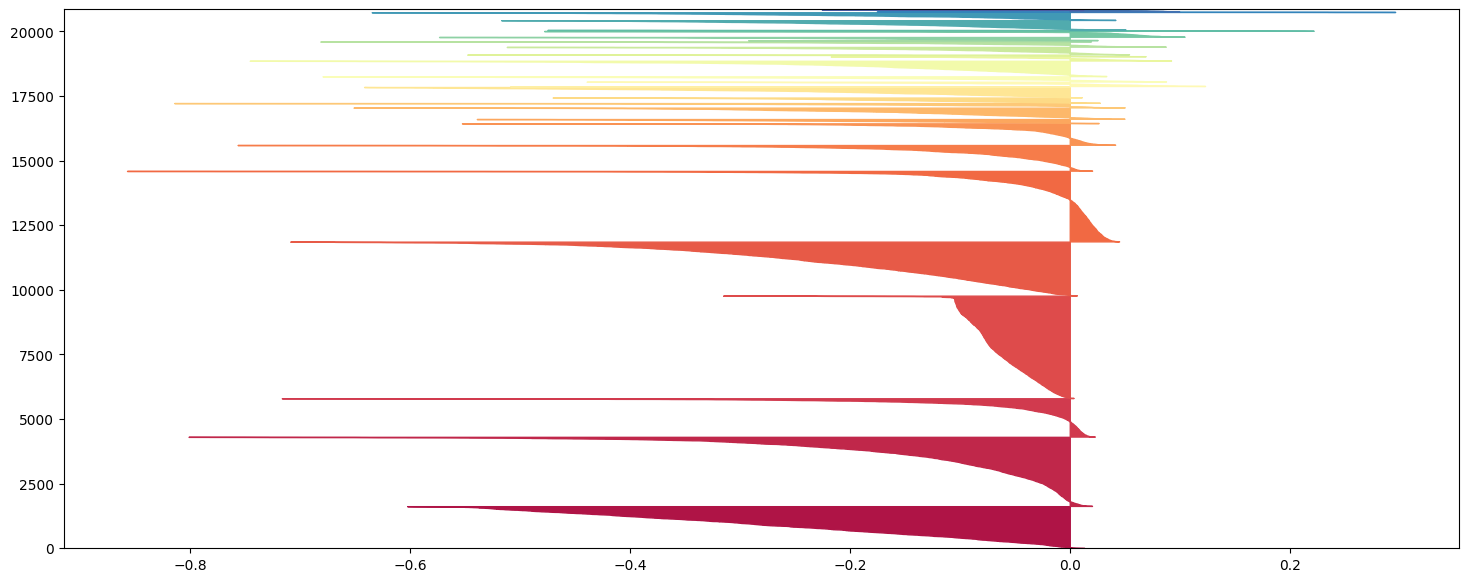

In [23]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

samples = silhouette_samples(
    X=distance_matrix.squareform(),
    labels=geohash_cluster_dataframe.df["cluster"],
    metric="precomputed",
)

new = geohash_cluster_dataframe.df.with_columns(
    pl.Series(
        name="sample",
        values=samples,
    )
)

n_clusters = len(geohash_cluster_dataframe.df["cluster"].unique())
n_geohashes = len(distance_matrix.squareform())

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_geohashes + (n_clusters + 1) * 10])

y_lower = 10
for i, cluster in enumerate(geohash_cluster_dataframe.df["cluster"].unique()):
    ith_cluster_silhouette_values = (new.filter(pl.col("cluster") == cluster).sort("sample", descending=True))["sample"]

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color =  cluster_colors_dataframe.get_color_for_cluster(cluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
    )

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


## `ClusterTaxaStatisticsDataFrame`

### Build

In [24]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geohash_taxa_counts_dataframe,
    geohash_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [25]:
cluster_taxa_statistics_dataframe.df.limit(3)

cluster,kingdom,taxonRank,scientificName,count,average
u32,enum,str,str,u32,f64
null,"""Fungi""","""SPECIES""","""Aleurodiscus cerussatus (Bres.…",1,1.9447e-8
null,"""Animalia""","""SPECIES""","""Thorybes casica""",151,0.000003
null,"""Plantae""","""VARIETY""","""Polemonium pulcherrimum var. p…",311,0.000006


## `ClusterSignificantDifferencesDataFrame`

### Build

In [26]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [27]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxon,percentage_difference
u32,str,f64
0,"""Opuntia polyacantha Haw.""",3783.177229
0,"""Cynomys ludovicianus (Ord, 181…",3958.621735
0,"""Bison bison (Linnaeus, 1758)""",2824.078945


## Build and plot GeoJSON feature collection

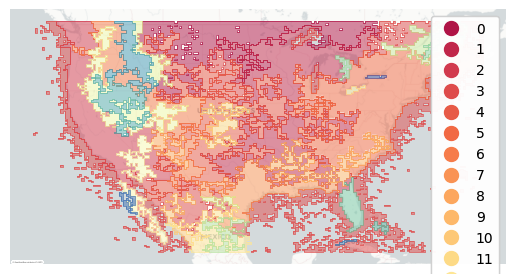

In [28]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# Build and display HTML output

In [ ]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


2.46108341217041

<Axes: >

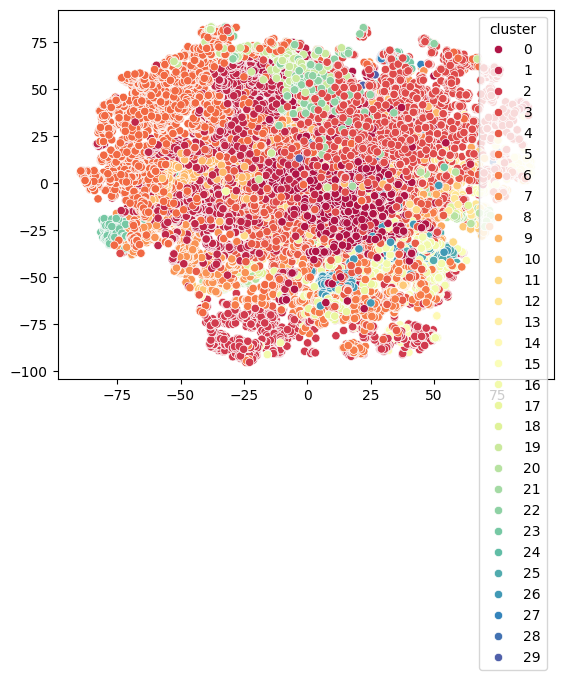

In [31]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=geohash_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

In [32]:
import seaborn as sns
import polars as pl
from scipy.cluster.hierarchy import linkage


linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geohashes = geohash_dataframe.df["geohash"].unique()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = geohash_cluster_dataframe.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species in cluster_significant_differences_dataframe.df["taxon"].unique():
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                # pl.col("kingdom") == kingdom, FIXME
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


ImportError: cannot import name 'TaxonRank' from 'src.darwin_core' (/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/src/darwin_core.py)

In [ ]:
data

In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)